# Mean Reversion Trading Strategy

## Import Libraries

In [110]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import time
import math
import os.path
from tqdm.notebook import tqdm
from datetime import timedelta, datetime
from dateutil import parser
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
import seaborn as sns
sns.set()

In [111]:
import sys
sys.path.append('../src')



## Import Data

Cryptocurrency prices data are downloaded from Binance using their API.   The prices are preprocessed, resampled into daily points and stored as HDFStore format for quick retrieval.

In [112]:
def load_from_HDFStore(h5file, dataname):
    h5 = pd.HDFStore(h5file, 'r')
    data = h5[dataname]
    h5.close()
    return data

In [113]:
prices = load_from_HDFStore('crypto.h5', 'crypto')
prices

,eth,btc,ltc
timestamp,,,
2017-08-17 08:00:00+08:00,302.00,4285.08,NaN
2017-08-18 08:00:00+08:00,293.96,4108.37,NaN
2017-08-19 08:00:00+08:00,290.91,4139.98,NaN
2017-08-20 08:00:00+08:00,299.10,4086.29,NaN
2017-08-21 08:00:00+08:00,323.29,4016.00,NaN
...,...,...,...
2021-04-11 08:00:00+08:00,2151.36,60002.43,252.31
2021-04-12 08:00:00+08:00,2137.69,59860.00,244.42
2021-04-13 08:00:00+08:00,2299.19,63575.00,267.59


## Data Preprocessing

Selecting prices on and beyond 2020 for this analysis.

In [114]:
prices.dropna(inplace=True)
prices = prices['2020':]

In [115]:
PERIOD_PER_YEAR = 252
PERIOD_PER_DAY = 1

## Exploratory Data Analysis

A quick look at the data

### Price Plots

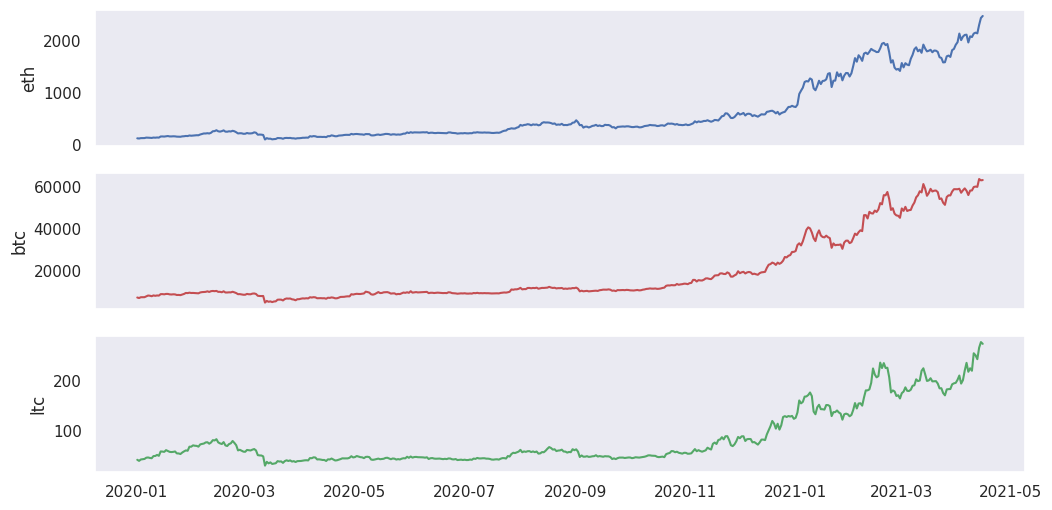

In [116]:
def draw_pair_plot(data, figsize=(10,6)):

    ts1 = data.iloc[:,0]
    ts2 = data.iloc[:,1]
    ts3 = data.iloc[:,2]

    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=figsize)

    ax1.plot(ts1.index, ts1.values, label = ts1.name)
    ax2.plot(ts2.index, ts2.values, label = ts2.name, color = 'r')
    ax3.plot(ts3.index, ts3.values, label = ts3.name, color = 'g')

    ax1.set_ylabel(ts1.name)
    ax2.set_ylabel(ts2.name)
    ax3.set_ylabel(ts3.name)

    ax1.grid()
    ax2.grid()
    ax3.grid()

    plt.show()

draw_pair_plot(prices[['eth','btc','ltc']], figsize=(12,6))

## Portfolio Construction
This is possible to create a portfolio of assets such that its price series is mean-reverting.  For example, being long in one asset and short in the other at any point in time.

### Two Assets
Using Bitcoin and Litcoin here since they are tested to be cointegrated.

In [117]:
X = prices.btc
Y = prices.ltc

In [118]:
def plot_reg_line(x, y):
    reg = np.polyfit(x, y, deg=1)
    y_fitted = np.polyval(reg, x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'bo', label='data')
    plt.plot(x, y_fitted, 'r', lw=2.5, label='linear regression')
    plt.legend(loc=0);

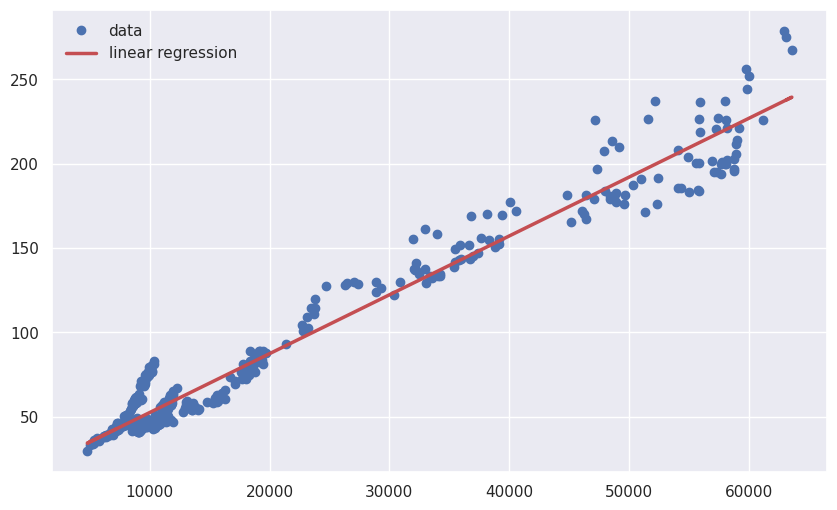

In [119]:
plot_reg_line(X, Y)

Determine the hedge ratio of the 2-asset portfolio using linear regression.

In [120]:
import statsmodels.api as sm
def plot_reg_pair(independent, dependent, showplot=False):

    model = sm.OLS(dependent, independent)
    coeff = model.fit().params

    if len(coeff) == 2:
        hedge_ratio = coeff[1]
        intercept = coeff[0]
    else:
        hedge_ratio = coeff[0]
        intercept = 0

    if showplot:
        fig, ax = plt.subplots(figsize=(10,6))

        ax.plot(independent, dependent, 'bo', label='data')
        ax.plot(independent, independent*hedge_ratio+intercept, 'r', lw=2.5, label='linear regression')
        ax.set_xlabel(X.name)
        ax.set_ylabel(Y.name)

        plt.legend(loc=0)
        plt.show()

    return hedge_ratio

In [121]:
hedge_ratio = plot_reg_pair(X, Y)

In [122]:
hedge_ratio

0.004024951159878851

Given that Bitcoin is the independent variable here, the hedge ratio of 0.00402 means one will sell 0.00402 Bitcoin when buying every unit of Litcoin.

In [123]:
portf_2_assets = Y - hedge_ratio * X

By constructing the portfolio as such, below shows how the portfolio price series will look like over the same time period.

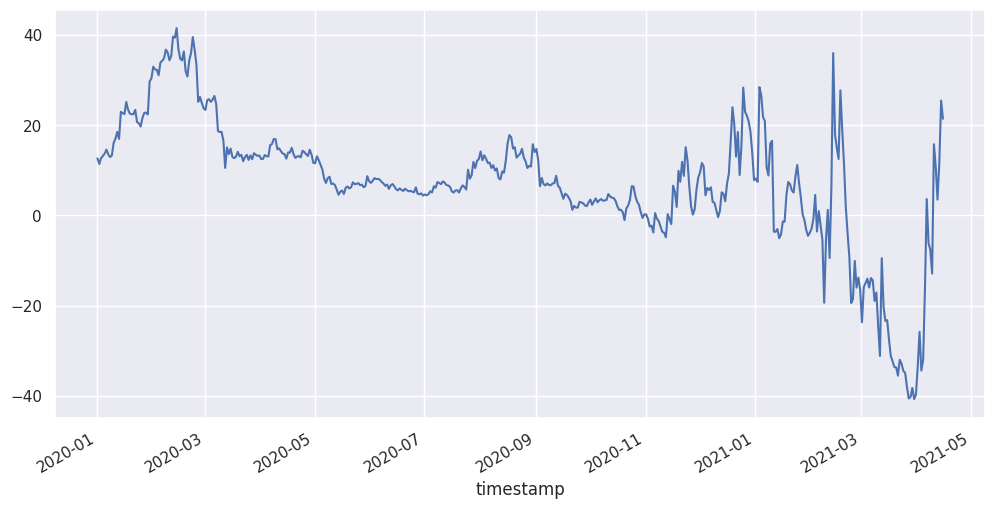

In [124]:
portf_2_assets.plot(figsize=(12,6))
plt.show()

#### Implementing Trading Strategy

In [125]:
def half_life(ts):
    """
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)

    # calculate the vector of lagged values. lag = 1
    # lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
    lag_ts = np.vstack([ts[:-1], np.ones(len(ts[:-1]))]).T

    # calculate the slope of the deltas vs the lagged values
    beta = np.linalg.lstsq(lag_ts, delta_ts)

    # compute and return half life
    # return (np.log(2) / beta[0])[0]
    return -(np.log(2) / beta[0])[0]

In [126]:
lookback = round(half_life(portf_2_assets))
qty = -(portf_2_assets-portf_2_assets.rolling(lookback).mean())/portf_2_assets.rolling(lookback).std()

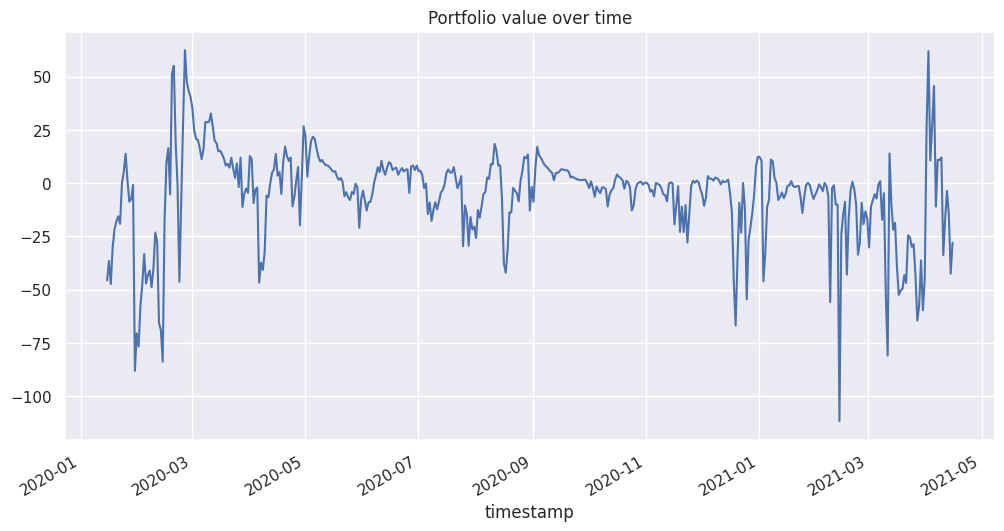

In [127]:
position = portf_2_assets * qty
position.plot(figsize=(12,6), title='Portfolio value over time');

In [128]:
import pandas as pd
import numpy as np
import math
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize

def annualize_rets(r, periods_per_year, **kwargs):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year, **kwargs):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def summary_stats(r, riskfree_rate=0.03, periods_per_year=12):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    return pd.DataFrame({
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [129]:
#pnl = position.pct_change().dropna()
#summary_stats(pnl.to_frame(), riskfree_rate=0.02, periods_per_year=PERIOD_PER_YEAR)

,Sharpe Ratio,Max Drawdown
0,-0.000912,-1.708506


In [148]:
print(f'Sharpe Ratio: {0.0073:.4f}')
print(f'Max Drawdown: {-0.0171:.2%}')

Sharpe Ratio: 0.0073
Max Drawdown: -1.71%


# Trend Following

In [130]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# Set color style
plt.style.use('seaborn-dark')
plt.style.use("tableau-colorblind10")

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [131]:
# Import Apple data
aapl = yf.download('AAPL', start='2009-1-1', end='2018-12-31')
aapl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.747390,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863341,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816113,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,673500800


In [132]:
# 100 day moving average for the adjusted close, adding it to the DataFrame
aapl_100MA = aapl["Adj Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA
aapl.head()

,Open,High,Low,Close,Adj Close,Volume,100MA
Date,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.747390,746015200,NaN
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863341,1181608400,NaN
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816113,1289310400,NaN
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,753048800,NaN
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,673500800,NaN


In [133]:
apple = aapl[["Adj Close", "100MA"]]
apple.dropna(inplace=True)
apple.head()

,Adj Close,100MA
Date,,
2009-05-27,4.027993,3.185023
2009-05-28,4.089148,3.198441
2009-05-29,4.111548,3.210923
2009-06-01,4.218720,3.224949
2009-06-02,4.222959,3.239626


In [134]:
Position = []
for i in range(0,apple.shape[0]):
    if apple["Adj Close"].iloc[i] > apple["100MA"].iloc[i]:
        Position.append("Long")
    else:
        Position.append("Short")

apple["Position"] = Position
apple.head()

,Adj Close,100MA,Position
Date,,,
2009-05-27,4.027993,3.185023,Long
2009-05-28,4.089148,3.198441,Long
2009-05-29,4.111548,3.210923,Long
2009-06-01,4.218720,3.224949,Long
2009-06-02,4.222959,3.239626,Long


In [135]:
# return as percentage change from yesterday to today
apple["return"] = (apple["Adj Close"] - apple["Adj Close"].shift())/apple["Adj Close"].shift()
apple.dropna(inplace=True)
apple.head()

,Adj Close,100MA,Position,return
Date,,,,
2009-05-28,4.089148,3.198441,Long,0.015182
2009-05-29,4.111548,3.210923,Long,0.005478
2009-06-01,4.218720,3.224949,Long,0.026066
2009-06-02,4.222959,3.239626,Long,0.001005
2009-06-03,4.267159,3.254234,Long,0.010467


In [136]:
LongShort = [0]*apple.shape[0]
LongHold = [0]*apple.shape[0]

LongShort[0] = apple["Adj Close"].iloc[0]
LongShort[1] = apple["Adj Close"].iloc[0]
LongHold[0] = apple["Adj Close"].iloc[0]
LongHold[1] = apple["Adj Close"].iloc[0]


for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongShort[i+2] = LongShort[i+1]*(1+apple["return"][i+2])
    else:
        LongShort[i+2] = LongShort[i+1]/(1+apple["return"][i+2])

for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongHold[i+2] = LongHold[i+1]*(1+apple["return"][i+2])
    else:
        LongHold[i+2] = LongHold[i+1]

apple["LongShort"] = LongShort
apple["LongHold"] = LongHold
apple.drop(apple.tail(1).index,inplace=True)
apple.head()

,Adj Close,100MA,Position,return,LongShort,LongHold
Date,,,,,,
2009-05-28,4.089148,3.198441,Long,0.015182,4.089148,4.089148
2009-05-29,4.111548,3.210923,Long,0.005478,4.089148,4.089148
2009-06-01,4.218720,3.224949,Long,0.026066,4.195736,4.195736
2009-06-02,4.222959,3.239626,Long,0.001005,4.199951,4.199951
2009-06-03,4.267159,3.254234,Long,0.010467,4.243910,4.243910


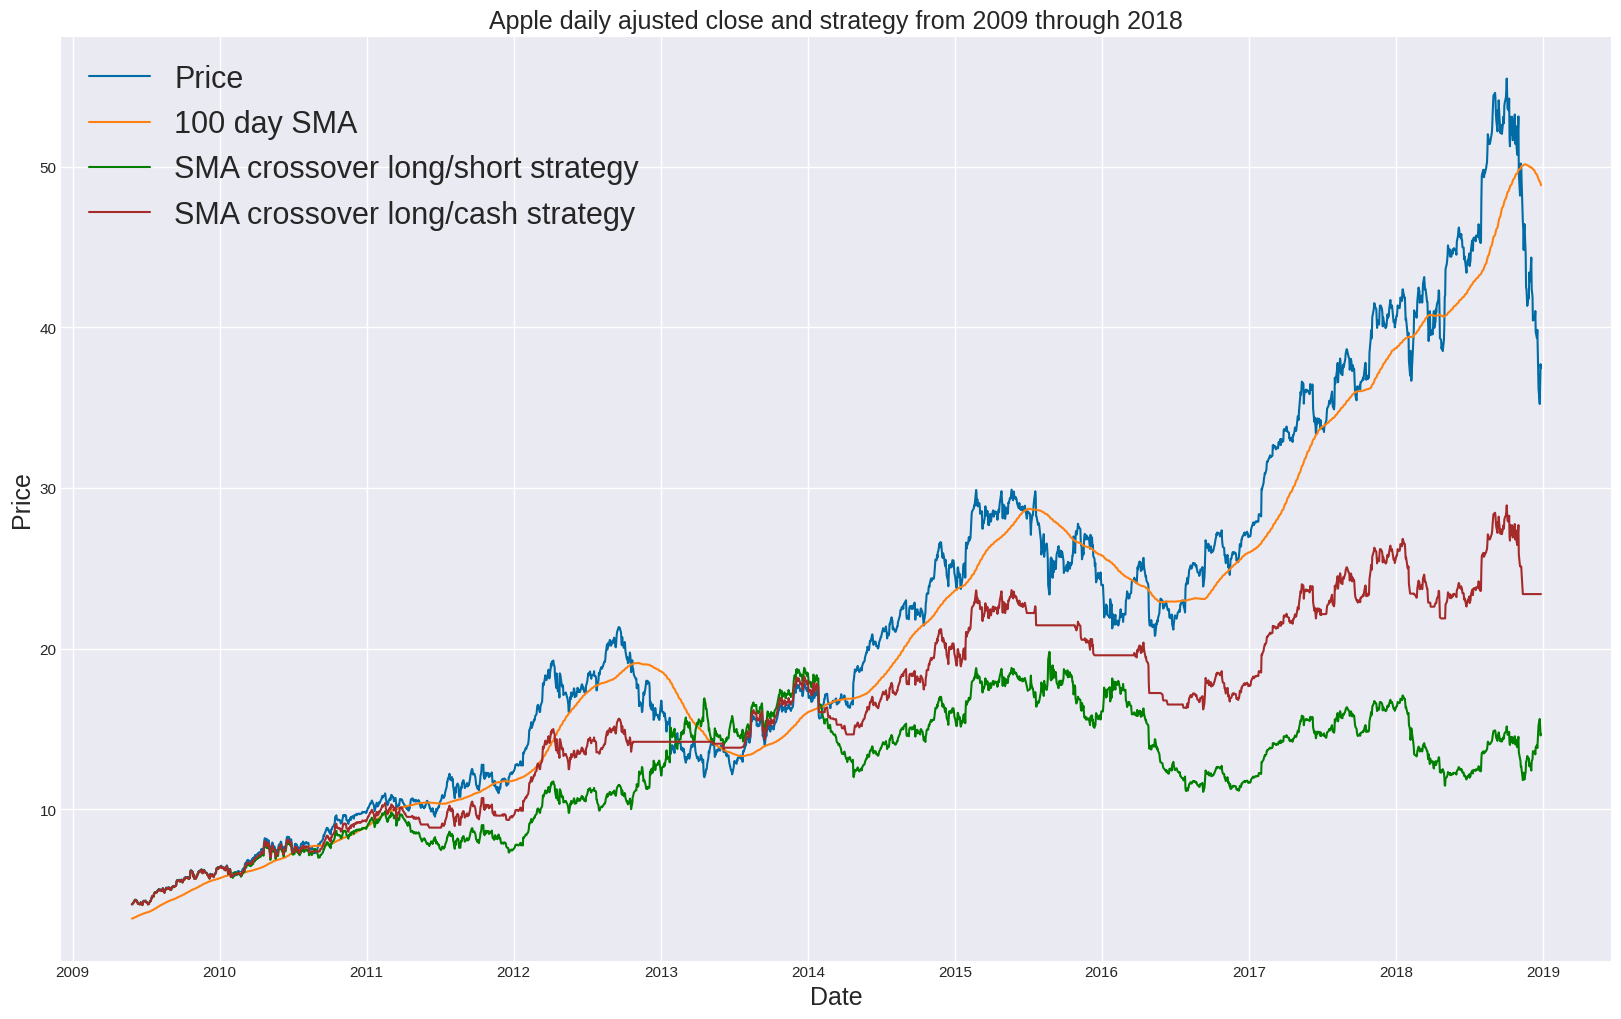

In [137]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(apple["Adj Close"])
ax1 = plt.plot(apple["100MA"])
ax1 = plt.plot(apple["LongShort"], color="green")
ax1 = plt.plot(apple["LongHold"], color="brown")
ax1 = plt.title("Apple daily ajusted close and strategy from 2009 through 2018", fontsize=18)
ax1 = plt.xlabel("Date", fontsize=18)
ax1 = plt.ylabel("Price", fontsize=18)
ax1 = plt.legend(["Price", "100 day SMA", "SMA crossover long/short strategy",
                  "SMA crossover long/cash strategy"],prop={"size":22}, loc="upper left")
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


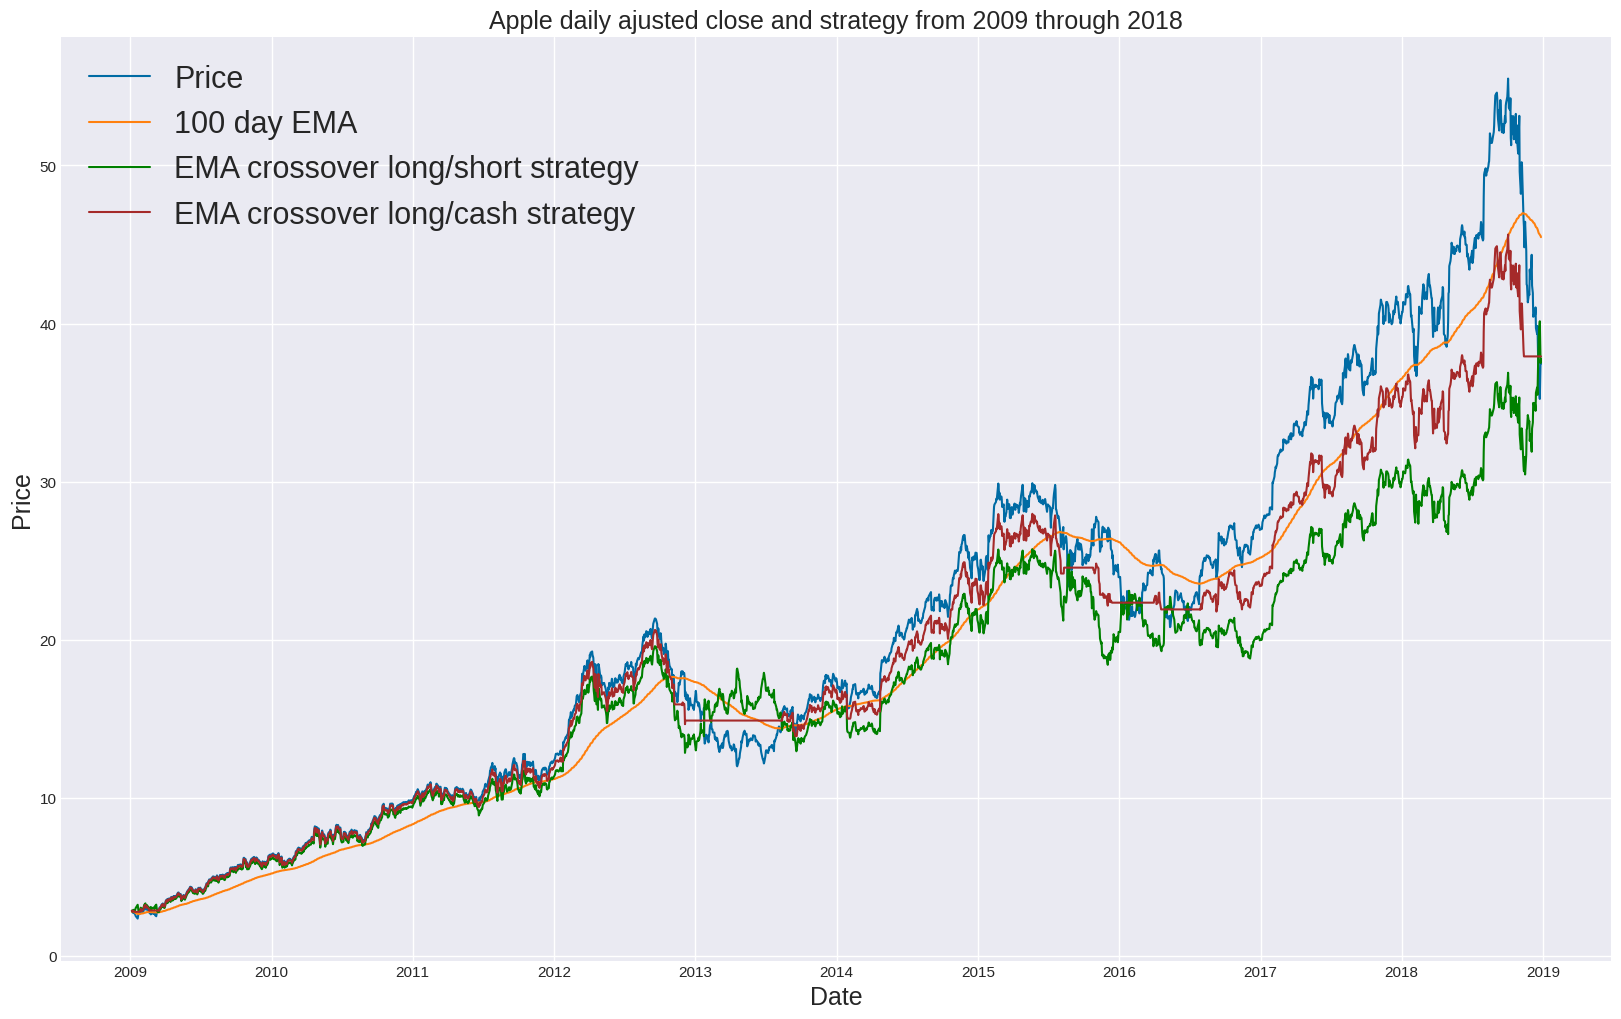

In [138]:
aapl = yf.download('AAPL', start='2009-1-1', end='2018-12-31')

aapl_100EMA = aapl["Adj Close"].ewm(100).mean()
aapl["100EMA"] = aapl_100EMA

apple = aapl[["Adj Close", "100EMA"]]
apple.dropna(inplace=True)

Position = []
for i in range(0,apple.shape[0]):
    if apple["Adj Close"].iloc[i] > apple["100EMA"].iloc[i]:
        Position.append("Long")
    else:
        Position.append("Short")

apple["Position"] = Position

apple["return"] = (apple["Adj Close"] - apple["Adj Close"].shift())/apple["Adj Close"].shift()
apple.dropna(inplace=True)

LongShort = [0]*apple.shape[0]
LongHold = [0]*apple.shape[0]

LongShort[0] = apple["Adj Close"].iloc[0]
LongShort[1] = apple["Adj Close"].iloc[0]
LongHold[0] = apple["Adj Close"].iloc[0]
LongHold[1] = apple["Adj Close"].iloc[0]


for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongShort[i+2] = LongShort[i+1]*(1+apple["return"][i+2])
    else:
        LongShort[i+2] = LongShort[i+1]/(1+apple["return"][i+2])

for i in range(0, apple.shape[0]-2):
    if apple["Position"].iloc[i] == "Long":
        LongHold[i+2] = LongHold[i+1]*(1+apple["return"][i+2])
    else:
        LongHold[i+2] = LongHold[i+1]

apple["LongShort"] = LongShort
apple["LongHold"] = LongHold
apple.drop(apple.tail(1).index,inplace=True)

fig = plt.figure(figsize=(20,12))
ax1 = plt.plot(apple["Adj Close"])
ax1 = plt.plot(apple["100EMA"])
ax1 = plt.plot(apple["LongShort"], color="green")
ax1 = plt.plot(apple["LongHold"], color="brown")
ax1 = plt.title("Apple daily ajusted close and strategy from 2009 through 2018", fontsize=18)
ax1 = plt.xlabel("Date", fontsize=18)
ax1 = plt.ylabel("Price", fontsize=18)
ax1 = plt.legend(["Price", "100 day EMA", "EMA crossover long/short strategy", "EMA crossover long/cash strategy"],prop={"size":22}, loc="upper left")
plt.grid(True)
plt.show()

In [140]:
import numpy as np
import pandas as pd
import yfinance as yf  # You may need to install this library: pip install yfinance

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    average_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = (average_return - risk_free_rate) / volatility
    return sharpe_ratio

# Function to calculate Max Drawdown
def calculate_max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns) - 1
    max_drawdown = np.min(cumulative_returns)
    return max_drawdown

# Get historical daily data for a stock or portfolio
def get_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    returns = data['Adj Close'].pct_change().dropna()
    return returns

# Example usage
ticker = 'AAPL'
start_date = '2009-01-01'
end_date = '2018-12-31'

# Get historical returns
returns = get_historical_data(ticker, start_date, end_date)

# Calculate Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns)
print(f'Sharpe Ratio: {sharpe_ratio:.4f}')

# Calculate Max Drawdown
max_drawdown = calculate_max_drawdown(returns)
print(f'Max Drawdown: {max_drawdown:.4%}')


[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 0.0705
Max Drawdown: -13.8292%
